# Flux calibration

Photometric and spectroscopic measurements of directly imaged planets typically provide the flux contrast between the companion and star. To calibrate the contrast of the companion to a flux or apparent magnitude requires an absolute measurement of the stellar flux.

In this tutorial, we will we will fit the [Gaia DR3](https://www.cosmos.esa.int/web/gaia/home) and [2MASS](https://irsa.ipac.caltech.edu/Missions/2mass.html) magnitudes of the G7 type star [PZ Tel](http://simbad.u-strasbg.fr/simbad/sim-basic?Ident=PZ+Tel) with the [BT-NextGen](http://svo2.cab.inta-csic.es/svo/theory/newov2/index.php?models=bt-nextgen-agss2009) model spectra. From the posterior samples, we will then compute synthetic photometry for the [VLT/ERIS M' filter](http://svo2.cab.inta-csic.es/svo/theory/fps/index.php?id=Paranal/ERIS.Mp&&mode=browse&gname=Paranal&gname2=ERIS#filter) and a synthetic spectrum for a given instrument resolution and wavelength binning.

## Getting started

We start by importing the required Python modules.

In [1]:
import calistar
import numpy as np

In [2]:
from species import SpeciesInit
from species.data.database import Database
from species.fit.fit_model import FitModel
from species.read.read_model import ReadModel
from species.plot.plot_mcmc import plot_posterior, plot_mag_posterior
from species.plot.plot_spectrum import plot_spectrum
from species.util.box_util import update_objectbox
from species.util.fit_util import get_residuals, multi_photometry

Next, we initiate the workflow by calling the [SpeciesInit](https://species.readthedocs.io/en/latest/species.core.html#species.core.species_init.SpeciesInit) class. This will create both the [HDF5 database](https://species.readthedocs.io/en/latest/database.html) and the [configuration file](https://species.readthedocs.io/en/latest/configuration.html) in the working folder.

In [3]:
SpeciesInit()

species v0.8.3

Working folder: /Users/tomasstolker/applications/species/docs/tutorials

Creating species_config.ini... [DONE]
Creating species_database.hdf5... [DONE]
Creating data folder... [DONE]

Configuration settings:
   - Database: /Users/tomasstolker/applications/species/docs/tutorials/species_database.hdf5
   - Data folder: /Users/tomasstolker/applications/species/docs/tutorials/data
   - Magnitude of Vega: 0.03

Multiprocessing: mpi4py not installed


We then create an instance of [Database](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database), which provides read and write access to the HDF5 database.

In [4]:
database = Database()

We will use the [calistar](https://calistar.readthedocs.io) tool to retrieve the Gaia DR3 parallax of [PZ Tel](http://simbad.u-strasbg.fr/simbad/sim-basic?Ident=PZ+Tel) and the Gaia, 2MASS, and WISE magnitudes. Similar to `species`, the `calistar` tool uses also the filter names as defined by the [SVO Filter Profile Service](http://svo2.cab.inta-csic.es/svo/theory/fps/). We start by creating an instance of the [CaliStar](https://calistar.readthedocs.io/en/latest/calistar.html#calistar.calistar.CaliStar) class for which we provide the Gaia DR3 source ID of PZ Tel as input (see [Simbad](https://simbad.u-strasbg.fr/simbad/sim-basic?Ident=pz+tel)).

In [5]:
cal_star = calistar.CaliStar(gaia_source=6655168686921108864, gaia_release='DR3')

calistar v0.0.4

Next, we run the [target_star](https://calistar.readthedocs.io/en/latest/calistar.html#calistar.calistar.CaliStar.target_star) to retrieve the astrometric and photometric properties of PZ Tel, which are returned in a dictionary.

In [6]:
target_dict = cal_star.target_star(write_json=False)


-> Querying GAIA DR3...

INFO: Query finished. [astroquery.utils.tap.core]

GAIA DR3 source ID = 6655168686921108864
Reference epoch = 2016.0
Parallax = 21.16 +/- 0.02 mas

RA = 283.274586 deg +/- 0.0162 mas
Dec = -50.180907 deg +/- 0.0174 mas
Coordinates = +18h53m05.90s -50d10m51.27s

Proper motion RA = 16.27 +/- 0.02 mas/yr
Proper motion Dec = -85.52 +/- 0.02 mas/yr
Radial velocity = -3.59 +/- 1.55 km/s

G mag = 8.101660 +/- 0.003166
BP mag = 8.496099 +/- 0.005965
RP mag = 7.526747 +/- 0.005561
GRVS mag = 7.288631 +/- 0.009597

Effective temperature = 5214 K
Surface gravity = 4.25
Metallicity = -0.82
G-band extinction = 0.00

Astrometric excess noise = 0.11
RUWE = 0.95
Non single star = 0
Single star probability from DSC-Combmod = 1.00

XP continuous = True
XP sampled = True
RVS spectrum = False


/Users/tomasstolker/.pyenv/versions/3.11.5/envs/species3.11/lib/python3.11/site-packages/gaiaxpy/calibrator/external_instrument_model.py:57: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  bases['inverseBasesCoefficients'][0] = bases['inverseB


Storing Gaia XP plot: gaiaxp_6655168686921108864_0.jpg
Storing Gaia XP data: gaiaxp_6655168686921108864.dat

-> Querying Simbad...

Simbad ID = V* PZ Tel
Spectral type = G9IV

-> Querying VizieR...

2MASS source ID = 18530587-5010499
Separation between Gaia and 2MASS source = 1.2 mas

2MASS J mag = 6.856 +/- 0.021
2MASS H mag = 6.486 +/- 0.049
2MASS Ks mag = 6.366 +/- 0.024

ALLWISE source ID = J185305.88-501050.8
Separation between Gaia and WISE source = 16.2 mas

WISE W1 mag = 6.294 +/- 0.098
WISE W2 mag = 6.247 +/- 0.027
WISE W3 mag = 6.275 +/- 0.015
WISE W4 mag = 6.257 +/- 0.052

-> Querying Washington Double Star catalog...

WDS ID = 18531-5011
Companion = Aa,Ab
Observation 1 = 2007
Observation 2 = 2012
Separation 1 (arcsec) = 0.30
Separation 2 (arcsec) = 0.40
Position angle 1 (deg) = 62.00
Position angle 2 (deg) = 60.00
Magnitude 1 = 6.38
Magnitude 2 = 11.42

WDS ID = 18531-5011
Companion = AB
Observation 1 = 2007
Observation 2 = 2007
Separation 1 (arcsec) = 4.00
Separation 2 (a

We will then assign the parralax to a separate variable and write the magnitudes to a new dictionary.

In [7]:
parallax = target_dict['Gaia parallax']

In [8]:
magnitudes = {'GAIA/GAIA3.G': target_dict['GAIA/GAIA3.G'],
              'GAIA/GAIA3.Gbp': target_dict['GAIA/GAIA3.Gbp'],
              'GAIA/GAIA3.Grp': target_dict['GAIA/GAIA3.Grp'],
              'GAIA/GAIA3.Grvs': target_dict['GAIA/GAIA3.Grvs'],
              '2MASS/2MASS.J': target_dict['2MASS/2MASS.J'],
              '2MASS/2MASS.H': target_dict['2MASS/2MASS.H'],
              '2MASS/2MASS.Ks': target_dict['2MASS/2MASS.Ks']}

We also create a list of the filter names for use later on.

In [9]:
filters = list(magnitudes.keys())

## Adding stellar photometry

We can now store the parallax and magnitudes of PZ Tel in the database by using the [add_object](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database.add_object) method. This will also download a flux-calibrated spectrum of Vega and convert the magnitudes into fluxes.

In [10]:
database.add_object(object_name='PZ Tel',
                    parallax=parallax,
                    app_mag=magnitudes,
                    spectrum=None)


----------
Add object
----------

Object name: PZ Tel
Units: None
Deredden: None


100%|████████████████████████████████████████| 288k/288k [00:00<00:00, 207MB/s]


Adding spectrum: Vega
Reference: Bohlin et al. 2014, PASP, 126
URL: https://ui.adsabs.harvard.edu/abs/2014PASP..126..711B/abstract
Parallax (mas) = 21.16 +/- 0.02

Magnitudes:
   - GAIA/GAIA3.G:
      - Mean wavelength (um) = 2.1656e+00
      - Apparent magnitude = 8.10 +/- 0.00
      - Flux (W m-2 um-1) = 1.48e-11 +/- 4.32e-14
   - GAIA/GAIA3.Gbp:
      - Mean wavelength (um) = 2.1656e+00
      - Apparent magnitude = 8.50 +/- 0.01
      - Flux (W m-2 um-1) = 1.68e-11 +/- 9.21e-14
   - GAIA/GAIA3.Grp:
      - Mean wavelength (um) = 2.1656e+00
      - Apparent magnitude = 7.53 +/- 0.01
      - Flux (W m-2 um-1) = 1.27e-11 +/- 6.52e-14
   - GAIA/GAIA3.Grvs:
      - Mean wavelength (um) = 2.1656e+00
      - Apparent magnitude = 7.29 +/- 0.01
      - Flux (W m-2 um-1) = 1.13e-11 +/- 9.97e-14
   - 2MASS/2MASS.J:
      - Mean wavelength (um) = 2.1656e+00
      - Apparent magnitude = 6.86 +/- 0.02
      - Flux (W m-2 um-1) = 5.74e-12 +/- 1.11e-13
   - 2MASS/2MASS.H:
      - Mean wavelength (

## Adding a grid of model spectra

Next, we will download the *BT-NextGen* grid and add the spectra of a specified $T_\mathrm{eff}$ range to the database.

In [11]:
database.add_model('bt-nextgen', teff_range=(3000., 8000.))


-------------------------
Add grid of model spectra
-------------------------

Database tag: bt-nextgen
Model name: BT-NextGen



100%|████████████████████████████████████████| 359M/359M [00:00<00:00, 295GB/s]
SHA256 hash of downloaded file: e399945922e5a81e3f63c60b63c9f7c7869105e4d24634e480792fc4c534bfd4
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.



Unpacking 448/803 model spectra from BT-NextGen (343 MB)...data/bt-nextgen
data/bt-nextgen.tgz
 [DONE]

Wavelength range (um) = 0.1 - 5000
Sampling (lambda/d_lambda) = 2000
Teff range (K) = 3000.0 - 8000.0

Adding BT-NextGen model spectra... data/bt-nextgen/bt-nextgen_teff_8000_logg_5.0_feh_0.5_spec.dat

Grid points stored in the database:
   - Teff = [3000. 3100. 3200. 3300. 3400. 3500. 3600. 3700. 3800. 3900. 4000. 4100.
 4200. 4300. 4400. 4500. 4600. 4700. 4800. 4900. 5000. 5100. 5200. 5300.
 5400. 5500. 5600. 5700. 5800. 5900. 6000. 6100. 6200. 6300. 6400. 6500.
 6600. 6700. 6800. 6900. 7000. 7200. 7400. 7600. 7800. 8000.]
   - log(g) = [3. 4. 5. 6.]
   - [Fe/H] = [0.  0.3 0.5]

Number of grid points per parameter:
   - teff: 46
   - logg: 4
   - feh: 3

Number of stored grid points: 552
Number of interpolated grid points: 0
Number of missing grid points: 0


## Fitting the 2MASS fluxes with the calibration spectrum

Now that we have prepared the database, we can fit the photometric fluxes with the model grid. To do so, we use the [FitModel](https://species.readthedocs.io/en/latest/species.fit.html#species.fit.fit_model.FitModel) class, which provides a Bayesian framework for parameter estimation. The argument of `bounds` contains a dictionary with the uniform priors that are used. In this example, we fix $T_\mathrm{eff}$, $\log(g)$, and $[\mathrm{Fe}/\mathrm{H}]$, so we effectively scale the model spectrum to the data by adjusting the distance and radius. We will also account for a instrument-specific error inflation, relative to the actual uncertainties on the 2MASS fluxes (so allowing them to increase up to a factor of 10). Finally, the parallax is automatically included with a normal prior.

In [12]:
fit = FitModel(object_name='PZ Tel',
               model='bt-nextgen',
               bounds={'teff': None,
                       'logg': None,
                       'feh': (0., 0.),
                       'radius': (1., 20.),
                       'GAIA/GAIA3_error': (1., 20.),
                       '2MASS/2MASS_error': (1., 10.)},
               inc_phot=True,
               inc_spec=False,
               fit_corr=None,
               apply_weights=False,
               normal_prior=None)


-----------------
Fit model spectra
-----------------

Object name: PZ Tel
Model tag: bt-nextgen
Binary star: False
Blackbody components: 0
Teff interpolation range: (3000.0, 8000.0)

Interpolating 2MASS/2MASS.H... [DONE]
Interpolating 2MASS/2MASS.J... [DONE]
Interpolating 2MASS/2MASS.Ks... [DONE]
Interpolating GAIA/GAIA3.G... [DONE]
Interpolating GAIA/GAIA3.Gbp... [DONE]
Interpolating GAIA/GAIA3.Grp... [DONE]
Interpolating GAIA/GAIA3.Grvs... [DONE]

Fixing 1 parameters:
   - feh = 0.0

Fitting 6 parameters:
   - teff
   - logg
   - radius
   - parallax
   - 2MASS/2MASS_error
   - GAIA/GAIA3_error

Uniform priors (min, max):
   - teff = (3000.0, 8000.0)
   - logg = (3.0, 6.0)
   - radius = (1.0, 20.0)
   - GAIA/GAIA3_error = (1.0, 20.0)
   - 2MASS/2MASS_error = (1.0, 10.0)

Normal priors (mean, sigma):
   - parallax = 21.16 +/- 0.02

Weights for the log-likelihood function:
   - 2MASS/2MASS.H = 1.00
   - 2MASS/2MASS.J = 1.00
   - 2MASS/2MASS.Ks = 1.00
   - GAIA/GAIA3.G = 1.00
   - GAI

We will sample the posterior distribution with the [run_dynesty](https://species.readthedocs.io/en/latest/species.fit.html#species.fit.fit_model.FitModel.run_dynesty), which uses the nested sampling implementation of [Dynesty](https://dynesty.readthedocs.io/en/latest/index.html). The samples will be stored in the database by the `tag` name. Let's run the sampler with 500 live points!

In [13]:
fit.run_dynesty(tag='pztel',
                n_live_points=500,
                output='dynesty/',
                resume=False,
                evidence_tolerance=0.5)


----------------------------
Nested sampling with Dynesty
----------------------------

Database tag: pztel
Number of live points: 500
Resume previous fit: False
Creating output folder: dynesty/



6561it [34:22,  1.07it/s, bound: 980 | nc: 298 | ncall: 752201 | eff(%):  0.872 | loglstar:   -inf < 195.726 <    inf | logz: 184.687 +/-  0.129 | dlogz:  0.817 >  0.500] /Users/tomasstolker/.pyenv/versions/3.11.5/envs/species3.11/lib/python3.11/site-packages/dynesty/bounding.py:618: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
6565it [34:29,  1.37s/it, bound: 983 | nc: 281 | ncall: 754662 | eff(%):  0.870 | loglstar:   -inf < 195.732 <    inf | logz: 184.688 +/-  0.129 | dlogz:  0.812 >  0.500] /Users/tomasstolker/.pyenv/versions/3.11.5/envs/species3.11/lib/python3.11/site-packages/dynesty/bounding.py:618: UserWarning: The enlargement fac


Samples shape: (7361, 6)
Number of iterations: 6861
Storing samples: dynesty/retrieval_post_equal_weights.dat

Nested sampling log-evidence: 184.91 +/- 0.25

Sample with the maximum likelihood:
   - Log-likelihood = 198.03
   - teff = 5531.65
   - logg = 4.42
   - radius = 11.08
   - parallax = 21.16
   - 2MASS/2MASS_error = 2.52
   - GAIA/GAIA3_error = 14.17

---------------------
Add posterior samples
---------------------

Database tag: pztel
Sampler: dynesty
Samples shape: (7361, 7)
Ln(Z): 184.91 +/- 0.25

Integrated autocorrelation time:
   - teff: 0.96
   - logg: 0.99
   - radius: 1.00
   - parallax: 0.96
   - 2MASS/2MASS_error: 0.97
   - GAIA/GAIA3_error: 1.09
   - feh: fixed


## Plotting the posterior distribution

After running the sampler, we can plot the posterior distribution of the 3 free parameters with the [plot_posterior](https://species.readthedocs.io/en/latest/species.plot.html#species.plot.plot_mcmc.plot_posterior) by simply pointing to the database `tag` that was specified with [run_dynesty](https://species.readthedocs.io/en/latest/species.fit.html#species.fit.fit_model.FitModel.run_dynesty).


---------------------
Get posterior samples
---------------------

Database tag: pztel
Random samples: None
Samples shape: (7361, 7)

Parameters:
   - teff
   - logg
   - radius
   - parallax
   - 2MASS/2MASS_error
   - GAIA/GAIA3_error
   - feh

Uniform priors (min, max):
   - 2MASS/2MASS_error = (1.0, 10.0)
   - GAIA/GAIA3_error = (1.0, 20.0)
   - logg = (3.0, 6.0)
   - radius = (1.0, 20.0)
   - teff = (3000.0, 8000.0)

Normal priors (mean, sigma):
   - parallax = (21.162138650630606, 0.022285202518105507)

----------------------------
Plot posterior distributions
----------------------------

Database tag: pztel
Object type: star
Manual parameters: None

Median parameters:
   - teff = 5.30e+03
   - logg = 4.11e+00
   - radius = 1.18e+01
   - parallax = 2.12e+01
   - 2MASS/2MASS_error = 2.09e+00
   - GAIA/GAIA3_error = 4.64e+00
   - feh = 0.00e+00

Sample with highest probability:
   - teff = 5.53e+03
   - logg = 4.42e+00
   - radius = 1.11e+01
   - parallax = 2.12e+01
   - 2MASS/2M

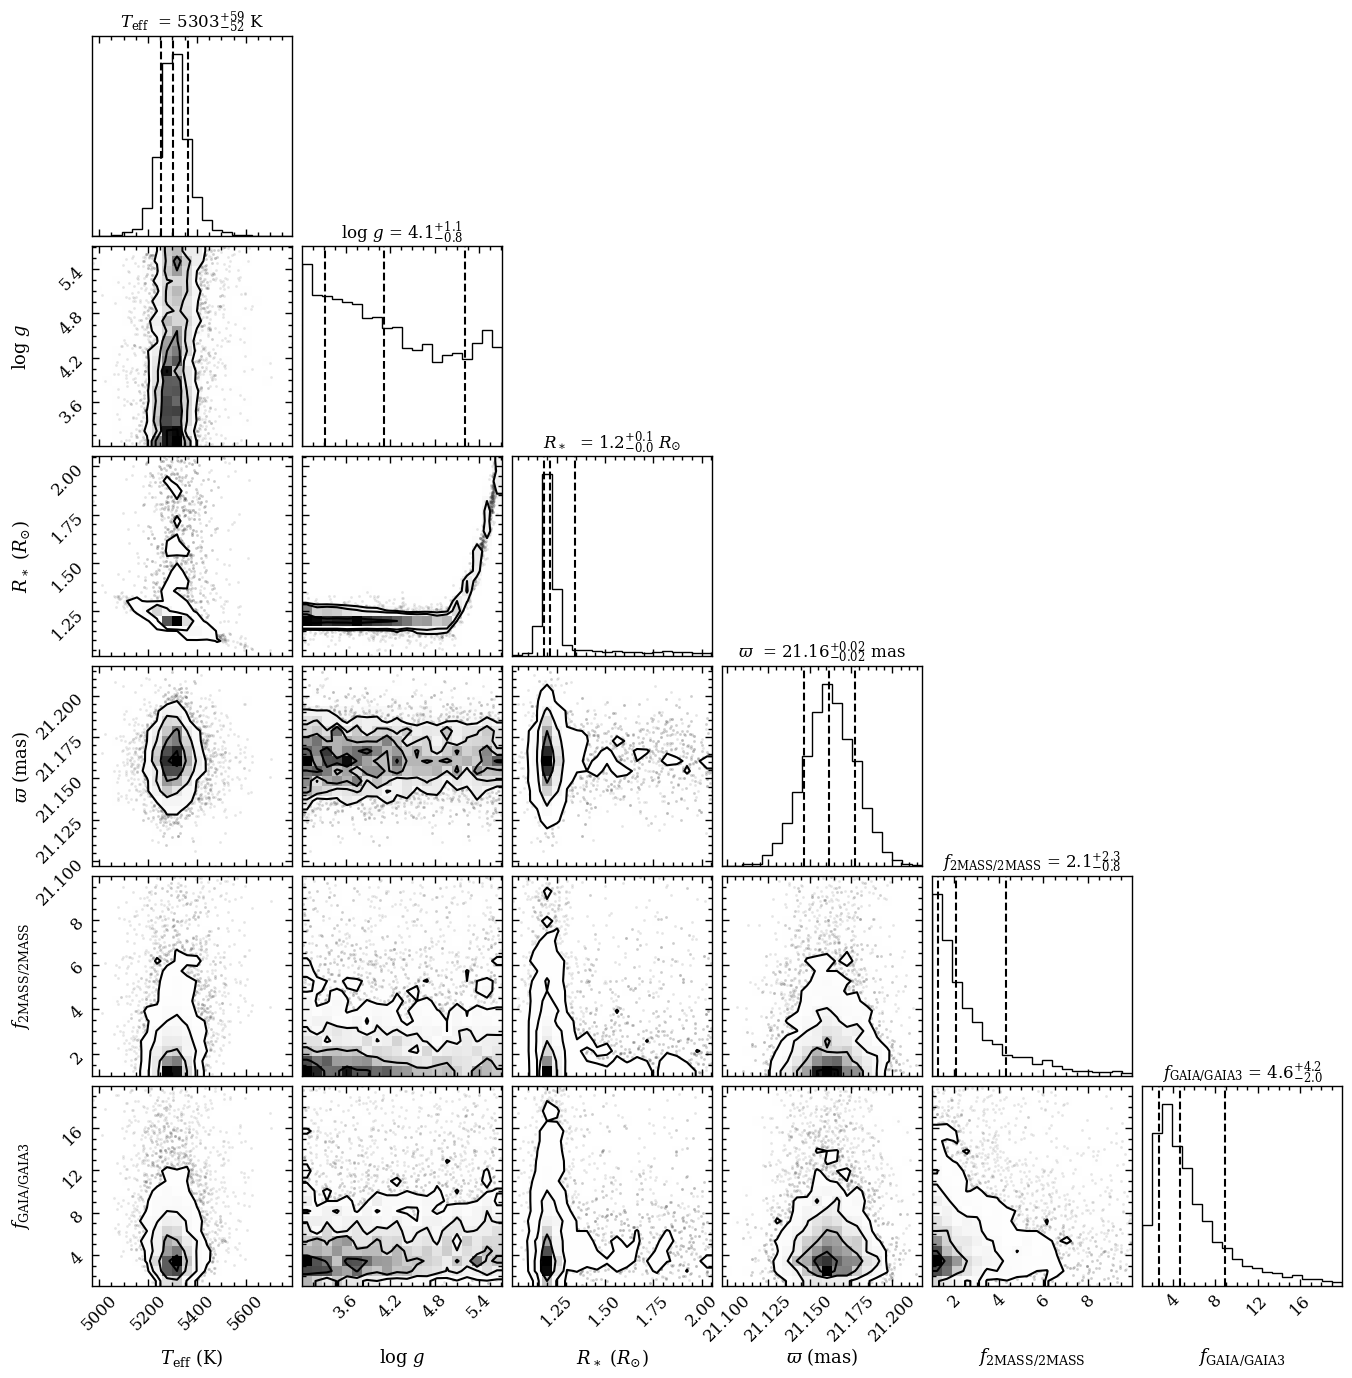

In [14]:
fig = plot_posterior(tag='pztel',
                     offset=(-0.3, -0.3),
                     title_fmt=['.0f', '.1f', '.1f', '.2f', '.1f', '.1f'],
                     object_type='star',
                     output=None)

The corner plot shows that the surface gravity, $\log{(g)}$, is unconstrained. That is to be expected when fitting only photometric fluxes. The [plot_posterior](https://species.readthedocs.io/en/latest/species.plot.html#species.plot.plot_mcmc.plot_posterior) function returned the [Figure](https://matplotlib.org/stable/api/figure_api.html#matplotlib.figure.Figure) object of the plot. The functionalities of [Matplotlib](https://matplotlib.org/stable/index.html) can be used for further customization of the plot. For example, the axes of the plot are stored at the `axes` attribute of `Figure`.

## Extracting spectral samples

Later on, we will create a plot of the data, best-fit spectrum, and random spectral samples of the posterior distribution. We start by drawing 30 random samples the posterior distribution and calculate spectra at $R = 100$. The [get_mcmc_spectra](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database.get_mcmc_spectra) method of [Database](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database) returns a list with [ModelBox](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.ModelBox) objects.

In [15]:
samples = database.get_mcmc_spectra(tag='pztel',
                                    random=30,
                                    wavel_range=(0.2, 10.),
                                    spec_res=100.)


---------------------
Get posterior spectra
---------------------

Database tag: pztel
Number of samples: 30
Wavelength range (um): (0.2, 10.0)
Resolution: 100.0



  0%|          | 0/30 [00:00<?, ?it/s]

/Users/tomasstolker/applications/species/species/read/read_model.py:665: UserWarning: The '2MASS/2MASS_error' parameter is not required by 'bt-nextgen' so the parameter will be ignored. The mandatory parameters are ['teff', 'logg', 'feh'].
  warnings.warn(
/Users/tomasstolker/applications/species/species/read/read_model.py:665: UserWarning: The 'GAIA/GAIA3_error' parameter is not required by 'bt-nextgen' so the parameter will be ignored. The mandatory parameters are ['teff', 'logg', 'feh'].
  warnings.warn(


Let's have a look at the content of the first [ModelBox](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.ModelBox) by using the [open_box](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.Box.open_box) method.

In [16]:
samples[0].open_box()

Opening ModelBox...
model = bt-nextgen
type = None
wavelength = [ 0.19990656  0.20000563  0.20010475 ...  9.99317824  9.99813088
 10.00308597]
flux = [6.65336224e-15 6.65654186e-15 6.65881037e-15 ... 3.54204838e-15
 3.53871413e-15 3.53564751e-15]
parameters = {'teff': 5233.318407273913, 'logg': 4.701898863952298, 'radius': 12.022594477059096, 'parallax': 21.148225167808945, '2MASS/2MASS_error': 1.3563052339023942, 'GAIA/GAIA3_error': 4.708313015056444, 'feh': 0.0, 'luminosity': 1.0315008690543477, 'mass': 2935.483973745513}
quantity = flux
contribution = None
bol_flux = None
spec_res = 100.0


Next, we extract the best-fit parameters from the posterior distribution, for which we adopt the sample with the highest likelihood value. The [get_probable_sample](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database.get_probable_sample) function returns a dictionary with the parameters, including the ones that were fixed with [FitModel](https://species.readthedocs.io/en/latest/species.fit.html#species.fit.fit_model.FitModel).

In [17]:
best_sample = database.get_probable_sample(tag='pztel')
print(best_sample)


--------------------------------------
Get sample with the maximum likelihood
--------------------------------------

Database tag: pztel

Parameters:
   - teff = 5531.65
   - logg = 4.42
   - radius = 11.08
   - parallax = 21.16
   - 2MASS/2MASS_error = 2.52
   - GAIA/GAIA3_error = 14.17
   - feh = 0.00
{'teff': 5531.646167736738, 'logg': 4.41991502839852, 'radius': 11.084949525377967, 'parallax': 21.16066384150121, '2MASS/2MASS_error': 2.5190603664349975, 'GAIA/GAIA3_error': 14.167943945128393, 'feh': 0.0}


Next, we interpolate the the *BT-NextGen* grid at the best-fit parameters. To do so, we first create an instance of [ReadModel](https://species.readthedocs.io/en/latest/species.read.html#species.read.read_model.ReadModel) and then use the [get_model](https://species.readthedocs.io/en/latest/species.read.html#species.read.read_model.ReadModel.get_model) method to interpolate the grid with the best-fit parameters that are provided as argument of `model_par`.  Similar to [get_mcmc_spectra](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database.get_mcmc_spectra), we also smooth this spectrum to $R = 100$. The model spectrum is again returned in a [ModelBox](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.ModelBox).

In [18]:
read_model = ReadModel(model='bt-nextgen', wavel_range=(0.2, 10.))
model_box = read_model.get_model(model_param=best_sample, spec_res=100.)

Each [Box](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.Box) is a [Python object](https://docs.python.org/3/tutorial/classes.html) so the content is easily accessed as attributes.

In [19]:
print(model_box.parameters)

{'teff': 5531.646167736738, 'logg': 4.41991502839852, 'radius': 11.084949525377967, 'parallax': 21.16066384150121, '2MASS/2MASS_error': 2.5190603664349975, 'GAIA/GAIA3_error': 14.167943945128393, 'feh': 0.0, 'luminosity': 1.0945852091620032, 'mass': 1303.6677461353454}


## Extracting the object data

For the plot, we also require the data of PZ Tel. These can be extracted with the [get_object](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database.get_object), which returns the data (e.g. photometry, spectra, and parallax) for a given `object_name`.

In [20]:
object_box = database.get_object(object_name='PZ Tel')


----------
Get object
----------

Object name: PZ Tel
Include photometry: True
Include spectra: True


The data are stored in an [ObjectBox](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.ObjectBox). Let's have a look at the content by using [open_box](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.Box.open_box).

In [21]:
object_box.open_box()

Opening ObjectBox...
name = PZ Tel
filters = ['2MASS/2MASS.H', '2MASS/2MASS.J', '2MASS/2MASS.Ks', 'GAIA/GAIA3.G', 'GAIA/GAIA3.Gbp', 'GAIA/GAIA3.Grp', 'GAIA/GAIA3.Grvs']
mean_wavel = {'2MASS/2MASS.H': 1.6513664598414621, '2MASS/2MASS.J': 1.24105170694321, '2MASS/2MASS.Ks': 2.1656311232670684, 'GAIA/GAIA3.G': 0.6390220344836051, 'GAIA/GAIA3.Gbp': 0.5182576434561539, 'GAIA/GAIA3.Grp': 0.7825078823058362, 'GAIA/GAIA3.Grvs': 0.8579038886678563}
magnitude = {'2MASS/2MASS.H': array([6.48600006, 0.049     ]), '2MASS/2MASS.J': array([6.85599995, 0.021     ]), '2MASS/2MASS.Ks': array([6.36600018, 0.024     ]), 'GAIA/GAIA3.G': array([8.10165977e+00, 3.16641662e-03]), 'GAIA/GAIA3.Gbp': array([8.49609852e+00, 5.96450345e-03]), 'GAIA/GAIA3.Grp': array([7.52674723e+00, 5.56069163e-03]), 'GAIA/GAIA3.Grvs': array([7.28863096, 0.00959738])}
flux = {'2MASS/2MASS.H': array([2.92837677e-12, 1.32204464e-13]), '2MASS/2MASS.J': array([5.74224978e-12, 1.11071881e-13]), '2MASS/2MASS.Ks': array([1.22822262e-12, 

With [FitModel](https://species.readthedocs.io/en/latest/species.fit.html#species.fit.fit_model.FitModel) it is possible to account for systematic uncertainties, either in the data or the model, for example to scale individual spectra or inflate the uncertainties. Since we inflated the 2MASS uncertainties during the fit, we will use the [update_objectbox](https://species.readthedocs.io/en/latest/species.util.html#species.util.box_util.update_objectbox) function to adjust the photometric precision with the best-fit error inflation as extracted with [get_probable_sample](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database.get_probable_sample).

In [22]:
object_box = update_objectbox(object_box, best_sample)


----------------
Update ObjectBox
----------------

Inflating the uncertainty of 2MASS/2MASS.H by a factor 2.52 to 3.33e-13 (W m-2 um-1)... [DONE]
Inflating the uncertainty of 2MASS/2MASS.J by a factor 2.52 to 2.80e-13 (W m-2 um-1)... [DONE]
Inflating the uncertainty of 2MASS/2MASS.Ks by a factor 2.52 to 6.84e-14 (W m-2 um-1)... [DONE]
Inflating the uncertainty of GAIA/GAIA3.G by a factor 14.17 to 6.11e-13 (W m-2 um-1)... [DONE]
Inflating the uncertainty of GAIA/GAIA3.Gbp by a factor 14.17 to 1.30e-12 (W m-2 um-1)... [DONE]
Inflating the uncertainty of GAIA/GAIA3.Grp by a factor 14.17 to 9.24e-13 (W m-2 um-1)... [DONE]
Inflating the uncertainty of GAIA/GAIA3.Grvs by a factor 14.17 to 1.41e-12 (W m-2 um-1)... [DONE]


## Residuals and synthetic photometry

Before creating the plot, there are two more boxes that we will create. First, we use the [get_residuals](https://species.readthedocs.io/en/latest/species.util.html#species.util.fit_util.get_residuals) function to calculate the residuals (i.e. data minus model, relative to the data uncertainties), together with the reduced $\chi^2$. The residuals and mean wavelengths are stored in a [ResidualsBox](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.ResidualsBox) for each of the 2MASS filters.

In [23]:
residuals = get_residuals(tag='pztel',
                          parameters=best_sample,
                          objectbox=object_box,
                          inc_phot=True,
                          inc_spec=False)


-------------------
Calculate residuals
-------------------


Model: bt-nextgen
Binary: False

Model parameters:
   - teff
   - logg
   - radius
   - parallax
   - 2MASS/2MASS_error
   - GAIA/GAIA3_error
   - feh

Fixed parameters:
   - feh

Include photometry: True
Include spectra: False

Residuals (sigma):
   - 2MASS/2MASS.H = 0.04
   - 2MASS/2MASS.J = 0.43
   - 2MASS/2MASS.Ks = 1.17
   - GAIA/GAIA3.G = -2.35
   - GAIA/GAIA3.Gbp = -1.45
   - GAIA/GAIA3.Grp = -0.95
   - GAIA/GAIA3.Grvs = -0.08

Number of data points = 7
Number of model parameters = 7
Number of fixed parameters = 1
Number of degrees of freedom = 1

chi2 = 10.12
reduced chi2 = 10.12


In [24]:
residuals.open_box()

Opening ResidualsBox...
name = PZ Tel
photometry = {'2MASS/2MASS.H': array([1.65136646, 0.03545684]), '2MASS/2MASS.J': array([1.24105171, 0.4290591 ]), '2MASS/2MASS.Ks': array([2.16563112, 1.17313044]), 'GAIA/GAIA3.G': array([ 0.63902203, -2.35419236]), 'GAIA/GAIA3.Gbp': array([ 0.51825764, -1.45121152]), 'GAIA/GAIA3.Grp': array([ 0.78250788, -0.94938028]), 'GAIA/GAIA3.Grvs': array([ 0.85790389, -0.08277787])}
spectrum = None
chi2_red = 10.117995575911728


Secondly, we will also use the dictionary with best-fit parameters to calculate synthetic photometry for the three filters that were used in the fit. The [multi_photometry](https://species.readthedocs.io/en/latest/species.util.html#species.util.fit_util.multi_photometry) returns a [SynphotBox](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.SynphotBox), which includes a dictionary with the photometric fluxes.

In [25]:
syn_phot = multi_photometry(datatype='model',
                            spectrum='bt-nextgen',
                            filters=filters,
                            parameters=best_sample)


--------------------------
Calculate multi-photometry
--------------------------

Data type: model
Spectrum name: bt-nextgen

Parameters:
   - teff = 5531.65
   - logg = 4.42
   - radius = 11.08
   - parallax = 21.16
   - 2MASS/2MASS_error = 2.52
   - GAIA/GAIA3_error = 14.17
   - feh = 0.00e+00
   - luminosity = 1.09
   - mass = 1303.67

Magnitudes:
   - GAIA/GAIA3.G = 8.00
   - GAIA/GAIA3.Gbp = 8.38
   - GAIA/GAIA3.Grp = 7.45
   - GAIA/GAIA3.Grvs = 7.28
   - 2MASS/2MASS.J = 6.88
   - 2MASS/2MASS.H = 6.49
   - 2MASS/2MASS.Ks = 6.45

Fluxes (W m-2 um-1):
   - GAIA/GAIA3.G = 1.62e-11
   - GAIA/GAIA3.Gbp = 1.87e-11
   - GAIA/GAIA3.Grp = 1.36e-11
   - GAIA/GAIA3.Grvs = 1.14e-11
   - 2MASS/2MASS.J = 5.61e-12
   - 2MASS/2MASS.H = 2.92e-12
   - 2MASS/2MASS.Ks = 1.14e-12


In [26]:
syn_phot.open_box()

Opening SynphotBox...
name = synphot
wavelength = {'GAIA/GAIA3.G': 0.6390220344836051, 'GAIA/GAIA3.Gbp': 0.5182576434561539, 'GAIA/GAIA3.Grp': 0.7825078823058362, 'GAIA/GAIA3.Grvs': 0.8579038886678563, '2MASS/2MASS.J': 1.24105170694321, '2MASS/2MASS.H': 1.6513664598414621, '2MASS/2MASS.Ks': 2.1656311232670684}
flux = {'GAIA/GAIA3.G': 1.6238907457776168e-11, 'GAIA/GAIA3.Gbp': 1.8659638929276605e-11, 'GAIA/GAIA3.Grp': 1.3609212769120217e-11, 'GAIA/GAIA3.Grvs': 1.1398165366980953e-11, '2MASS/2MASS.J': 5.613087170849889e-12, '2MASS/2MASS.H': 2.9156721500718107e-12, '2MASS/2MASS.Ks': 1.1418927124572785e-12}
app_mag = {'GAIA/GAIA3.G': (8.000633435331423, None), 'GAIA/GAIA3.Gbp': (8.379634409142344, None), 'GAIA/GAIA3.Grp': (7.454241064501924, None), 'GAIA/GAIA3.Grvs': (7.277405315478439, None), '2MASS/2MASS.J': (6.880700678622732, None), '2MASS/2MASS.H': (6.490720722363053, None), '2MASS/2MASS.Ks': (6.445129646476194, None)}
abs_mag = {'GAIA/GAIA3.G': (4.62827987553529, None), 'GAIA/GAIA3.Gb

## Plotting the data and model spectra

We have now prepared all the boxes with data so we are ready to combine them in a plot of the spectral energy distribution (SED) of PZ Tel! The [plot_spectrum](https://species.readthedocs.io/en/latest/species.plot.html#species.plot.plot_spectrum.plot_spectrum) function requires a list of [Box](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.Box) objects as argument of boxes. For each box we can set the plot style, by providing a list with dictionaries as argument of `plot_kwargs`, in the same order as the list of boxes. Items in the list can be set to `None`, in which case some default values are used. The [ResidualsBox](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.ResidualsBox) is passed as argument of `residuals` and will also plot the filter profiles by providing the list with names as argument to `filters`. Finally, there is a handful of parameters that can be adjusted for the appearance of the plot (see the API documentation of [plot_spectrum](https://species.readthedocs.io/en/latest/species.plot.html#species.plot.plot_spectrum.plot_spectrum) for details). Let's have a look at the plot!


-------------
Plot spectrum
-------------

Boxes:
   - List with 30 x ModelBox
   - ModelBox
   - ObjectBox

Object type: star
Quantity: flux
Units: ('um', 'W m-2 um-1')
Filter profiles: ['GAIA/GAIA3.G', 'GAIA/GAIA3.Gbp', 'GAIA/GAIA3.Grp', 'GAIA/GAIA3.Grvs', '2MASS/2MASS.J', '2MASS/2MASS.H', '2MASS/2MASS.Ks']

Figure size: (6.0, 4.0)
Legend parameters: None
Include model name: False


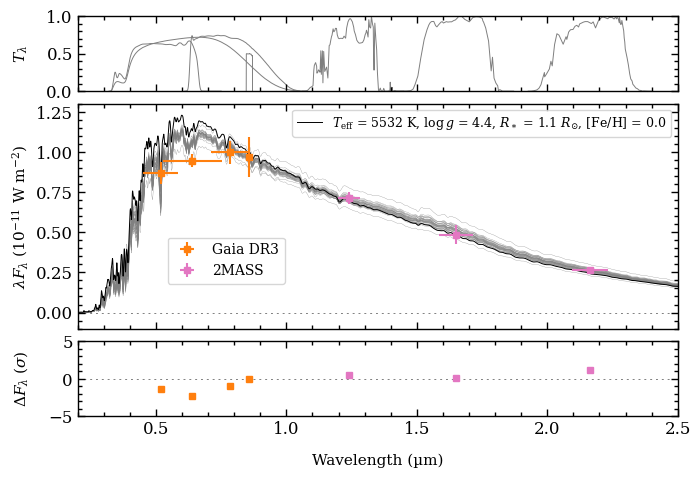

In [27]:
fig = plot_spectrum(boxes=[samples, model_box, object_box],
                    filters=filters,
                    residuals=residuals,
                    plot_kwargs=[{'ls': '-', 'lw': 0.2, 'color': 'gray'},
                                 {'ls': '-', 'lw': 0.7, 'color': 'black'},
                                 {'GAIA/GAIA3.G': {'marker': 's', 'ms': 5., 'color': 'tab:orange', 'ls': 'none', 'label': 'Gaia DR3'},
                                  'GAIA/GAIA3.Gbp': {'marker': 's', 'ms': 5., 'color': 'tab:orange', 'ls': 'none'},
                                  'GAIA/GAIA3.Grp': {'marker': 's', 'ms': 5., 'color': 'tab:orange', 'ls': 'none'},
                                  'GAIA/GAIA3.Grvs': {'marker': 's', 'ms': 5., 'color': 'tab:orange', 'ls': 'none'},
                                  '2MASS/2MASS.J': {'marker': 's', 'ms': 5., 'color': 'tab:pink', 'ls': 'none', 'label': '2MASS'},
                                  '2MASS/2MASS.H': {'marker': 's', 'ms': 5., 'color': 'tab:pink', 'ls': 'none'},
                                  '2MASS/2MASS.Ks': {'marker': 's', 'ms': 5., 'color': 'tab:pink', 'ls': 'none'}}],
                    xlim=(0.2, 2.5),
                    ylim=(-1.e-12, 1.3e-11),
                    ylim_res=(-5., 5.),
                    scale=('linear', 'linear'),
                    offset=(-0.5, -0.08),
                    figsize=(6., 4.),
                    object_type='star',
                    quantity='flux',
                    legend=[{'loc': 'upper right', 'fontsize': 9.},
                            {'loc': (0.15, 0.2), 'fontsize': 10.}],
                    output=None)

Note that the photometric uncertainties are inflated in the plot by the best-fit parameters that were fitted. These parameters had been applied to the data when running the [update_objectbox](https://species.readthedocs.io/en/latest/species.util.html#species.util.box_util.update_objectbox) on the [ObjectBox](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.ObjectBox).

The [plot_spectrum](https://species.readthedocs.io/en/latest/species.plot.html#species.plot.plot_spectrum.plot_spectrum) function returned the [Figure](https://matplotlib.org/stable/api/figure_api.html#matplotlib.figure.Figure) object of the plot. The functionalities of [Matplotlib](https://matplotlib.org/stable/index.html) can be used for further customization of the plot. For example, the axes of the plot are stored at the `axes` attribute of `Figure`.

In [28]:
fig.axes

[<Axes: ylabel='$\\lambda$$F_\\lambda$ (10$^{-11}$ W m$^{-2}$)'>,
 <Axes: ylabel='$T_\\lambda$'>,
 <Axes: xlabel='Wavelength (µm)', ylabel='$\\Delta$$F_\\lambda$ ($\\sigma$)'>]

## Photometric calibration

Now that we have the posterior samples of the atmospheric parameters, we can calculated synthetic photometry (including uncertainties) for any other filter. As an example, we will calculate the magnitude and flux for the VLT/ERIS $M'$ filter. The [plot_mag_posterior](https://species.readthedocs.io/en/latest/species.plot.html#species.plot.plot_mcmc.plot_mag_posterior) function plots the distribution of the magnitudes, by propagating the posterior of the atmospheric parameters, and returns an array with the samples. We simply need to specify the database `tag` and provide the `filter_name` name as listed on the [SVO Filter Profile Service](http://svo2.cab.inta-csic.es/svo/theory/fps/)). The function returns an [ndarray](https://numpy.org/doc/stable/reference/arrays.ndarray.html) with the samples and the [Figure](https://matplotlib.org/stable/api/figure_api.html#matplotlib.figure.Figure) of the plot that can be used for further customization.

Getting MCMC photometry:   0%|          | 0/7361 [00:00<?, ?it/s]

Plotting photometry samples...

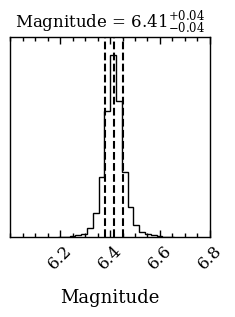

 [DONE]


In [29]:
phot_mag, fig = plot_mag_posterior(tag='pztel',
                                   filter_name='Paranal/ERIS.Mp',
                                   xlim=(6.0, 6.8),
                                   output=None)

There is also the [get_mcmc_photometry](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database.get_mcmc_photometry) method of [Database](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database), which works in a similar way as [plot_mag_posterior](https://species.readthedocs.io/en/latest/species.plot.html#species.plot.plot_mcmc.plot_mag_posterior), but can also return the posterior of the flux density instead of the magnitude.

In [30]:
phot_flux = database.get_mcmc_photometry(tag='pztel',
                                         filter_name='Paranal/ERIS.Mp',
                                         phot_type='flux')

Getting MCMC photometry:   0%|          | 0/7361 [00:00<?, ?it/s]

/Users/tomasstolker/applications/species/species/read/read_model.py:665: UserWarning: The '2MASS/2MASS_error' parameter is not required by 'bt-nextgen' so the parameter will be ignored. The mandatory parameters are ['teff', 'logg', 'feh'].
  warnings.warn(
/Users/tomasstolker/applications/species/species/read/read_model.py:665: UserWarning: The 'GAIA/GAIA3_error' parameter is not required by 'bt-nextgen' so the parameter will be ignored. The mandatory parameters are ['teff', 'logg', 'feh'].
  warnings.warn(


To calculate the flux density in the $M'$-band, we simply adopt the mean and the standard deviation of the distribution.

In [31]:
print(f'Flux density (W m-2 um-1) = {np.mean(phot_flux):.2e} +/- {np.std(phot_flux):.2e}')

Flux density (W m-2 um-1) = 5.77e-14 +/- 2.19e-15


## Spectral calibration

We can also compute a stellar, synthetic spectrum with uncertainties for a specific instrument. To do so, we use again the [get_mcmc_spectra](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database.get_mcmc_spectra) method from earlier, but this time we draw a larger number of spectra. Furthermore, for our hypothetical instrument, we assume a resolving power of $R = 100$ and set the wavelength points (20 linearly-spaced points between 1 and 2.5 $\mu$m) as argument of `wavel_resample`.

In [32]:
samples = database.get_mcmc_spectra(tag='pztel',
                                    random=100,
                                    wavel_range=(0.2, 10.),
                                    spec_res=100.,
                                    wavel_resample=np.linspace(1., 2.5, 20))


---------------------
Get posterior spectra
---------------------

Database tag: pztel
Number of samples: 100
Wavelength range (um): (0.2, 10.0)
Resolution: 100.0



  0%|          | 0/100 [00:00<?, ?it/s]

Next, we calculate the mean and standard deviation of the 100 samples, which we adopt as the synthetic spectrum of PZ Tel.

In [33]:
spec_flux = np.mean([box.flux for box in samples], axis=0)
spec_sigma = np.std([box.flux for box in samples], axis=0)

Let's write the synthetic spectrum to a text file. 

In [34]:
calib_spec = np.column_stack([samples[0].wavelength, spec_flux, spec_sigma])
np.savetxt('calib_spec.dat', calib_spec)

Now we can use the [add_object](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database.add_object) method to append the spectrum to the data of PZ Tel in the database. The parallax and magnitudes were already provided previously so we can set the arguments of `parallax` and `app_mag` to `None`.

In [35]:
database.add_object(object_name='PZ Tel',
                    parallax=None,
                    app_mag=None,
                    spectrum={'calibration': ('calib_spec.dat', None, 100.)})


----------
Add object
----------

Object name: PZ Tel
Units: None
Deredden: None

Spectra:
   - Spectrum:
      - Database tag: calibration
      - Filename: calib_spec.dat
      - Data shape: (20, 3)
      - Wavelength range (um): 1.00 - 2.50
      - Mean flux (W m-2 um-1): 3.23e-12
      - Mean error (W m-2 um-1): 7.98e-14
   - Instrument resolution:
      - calibration: 100.0


Next, we use the [get_object](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database.get_object) method for extracting all the data of PZ Tel from the database and storing these in an [ObjectBox](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.ObjectBox). We need to apply again the [update_objectbox](https://species.readthedocs.io/en/latest/species.util.html#species.util.box_util.update_objectbox) function to account for the inflated errors of the 2MASS fluxes.

In [36]:
object_box = database.get_object(object_name='PZ Tel')
object_box = update_objectbox(object_box, best_sample)


----------
Get object
----------

Object name: PZ Tel
Include photometry: True
Include spectra: True

----------------
Update ObjectBox
----------------

Inflating the uncertainty of 2MASS/2MASS.H by a factor 2.52 to 3.33e-13 (W m-2 um-1)... [DONE]
Inflating the uncertainty of 2MASS/2MASS.J by a factor 2.52 to 2.80e-13 (W m-2 um-1)... [DONE]
Inflating the uncertainty of 2MASS/2MASS.Ks by a factor 2.52 to 6.84e-14 (W m-2 um-1)... [DONE]
Inflating the uncertainty of GAIA/GAIA3.G by a factor 14.17 to 6.11e-13 (W m-2 um-1)... [DONE]
Inflating the uncertainty of GAIA/GAIA3.Gbp by a factor 14.17 to 1.30e-12 (W m-2 um-1)... [DONE]
Inflating the uncertainty of GAIA/GAIA3.Grp by a factor 14.17 to 9.24e-13 (W m-2 um-1)... [DONE]
Inflating the uncertainty of GAIA/GAIA3.Grvs by a factor 14.17 to 1.41e-12 (W m-2 um-1)... [DONE]


If we now open the [ObjectBox](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.ObjectBox) with [open_box](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.Box.open_box) then we see that the synthetic spectrum is indeed included together with the previously added data.

In [37]:
object_box.open_box()

Opening ObjectBox...
name = PZ Tel
filters = ['2MASS/2MASS.H', '2MASS/2MASS.J', '2MASS/2MASS.Ks', 'GAIA/GAIA3.G', 'GAIA/GAIA3.Gbp', 'GAIA/GAIA3.Grp', 'GAIA/GAIA3.Grvs']
mean_wavel = {'2MASS/2MASS.H': 1.6513664598414621, '2MASS/2MASS.J': 1.24105170694321, '2MASS/2MASS.Ks': 2.1656311232670684, 'GAIA/GAIA3.G': 0.6390220344836051, 'GAIA/GAIA3.Gbp': 0.5182576434561539, 'GAIA/GAIA3.Grp': 0.7825078823058362, 'GAIA/GAIA3.Grvs': 0.8579038886678563}
magnitude = {'2MASS/2MASS.H': array([6.48600006, 0.049     ]), '2MASS/2MASS.J': array([6.85599995, 0.021     ]), '2MASS/2MASS.Ks': array([6.36600018, 0.024     ]), 'GAIA/GAIA3.G': array([8.10165977e+00, 3.16641662e-03]), 'GAIA/GAIA3.Gbp': array([8.49609852e+00, 5.96450345e-03]), 'GAIA/GAIA3.Grp': array([7.52674723e+00, 5.56069163e-03]), 'GAIA/GAIA3.Grvs': array([7.28863096, 0.00959738])}
flux = {'2MASS/2MASS.H': array([2.92837677e-12, 3.58312271e-13]), '2MASS/2MASS.J': array([5.74224978e-12, 3.01036870e-13]), '2MASS/2MASS.Ks': array([1.22822262e-12, 

Let's have a look at the content of the returned [ObjectBox](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.ObjectBox) by simply passing it to the [plot_spectrum](https://species.readthedocs.io/en/latest/species.plot.html#species.plot.plot_spectrum.plot_spectrum) function!


-------------
Plot spectrum
-------------

Boxes:
   - ObjectBox

Object type: planet
Quantity: flux density
Units: ('um', 'W m-2 um-1')
Filter profiles: None

Figure size: (6.0, 3.0)
Legend parameters: None
Include model name: False


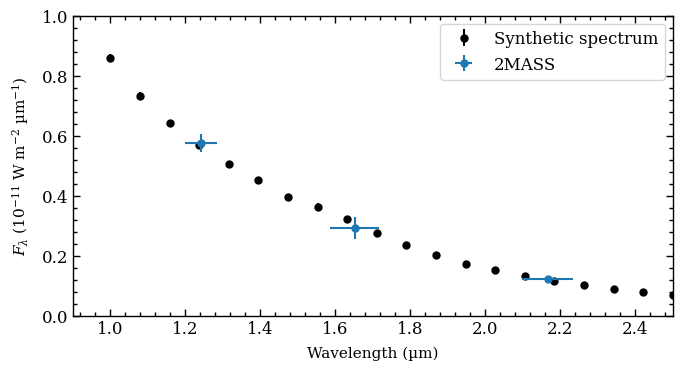

In [38]:
fig = plot_spectrum(boxes=[object_box],
                    plot_kwargs=[{'calibration': {'marker': 'o', 'ms': 5., 'color': 'black', 'ls': 'none', 'label': 'Synthetic spectrum'},
                                  '2MASS/2MASS.J': {'marker': 'o', 'ms': 5., 'color': 'tab:blue', 'ls': 'none', 'label': '2MASS'},
                                  '2MASS/2MASS.H': {'marker': 'o', 'ms': 5., 'color': 'tab:blue', 'ls': 'none'},
                                  '2MASS/2MASS.Ks': {'marker': 'o', 'ms': 5., 'color': 'tab:blue', 'ls': 'none'}}],
                    xlim=(0.9, 2.5),
                    ylim=(0., 1e-11),
                    scale=('linear', 'linear'),
                    offset=(-0.1, -0.07),
                    figsize=(6., 3.),
                    legend={'loc': 'upper right', 'fontsize': 12.},
                    output=None)

The [plot_spectrum](https://species.readthedocs.io/en/latest/species.plot.html#species.plot.plot_spectrum.plot_spectrum) function returned the [Figure](https://matplotlib.org/stable/api/figure_api.html#matplotlib.figure.Figure) object of the plot. The functionalities of [Matplotlib](https://matplotlib.org/stable/index.html) can be used for further customization of the plot. For example, the axes of the plot are stored at the `axes` attribute of `Figure`.

In [39]:
fig.axes

[<Axes: xlabel='Wavelength (µm)', ylabel='$F_\\lambda$ (10$^{-11}$ W m$^{-2}$ µm$^{-1}$)'>]